# Objetivo:
1. Ajustar os dados do índice de isolamento da cidade de São Paulo com um polinômio
2. Utilizar $\theta$ vomo função do tempo
3. Ajustar o modelo sem vacinação com $\theta$ variável

In [1]:
# Carregando librarias
# from sympy import transpose as tp
import numpy as np
import pandas as pd
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial import polynomial as poly
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from myfunctions import rk4
from scipy.integrate import odeint

In [2]:
# parâmetros para ajustar o tamanho das figuras
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Computar as médias móveis de 7, 14 e 21 dias a partir dos dados reais do índice de isolamento

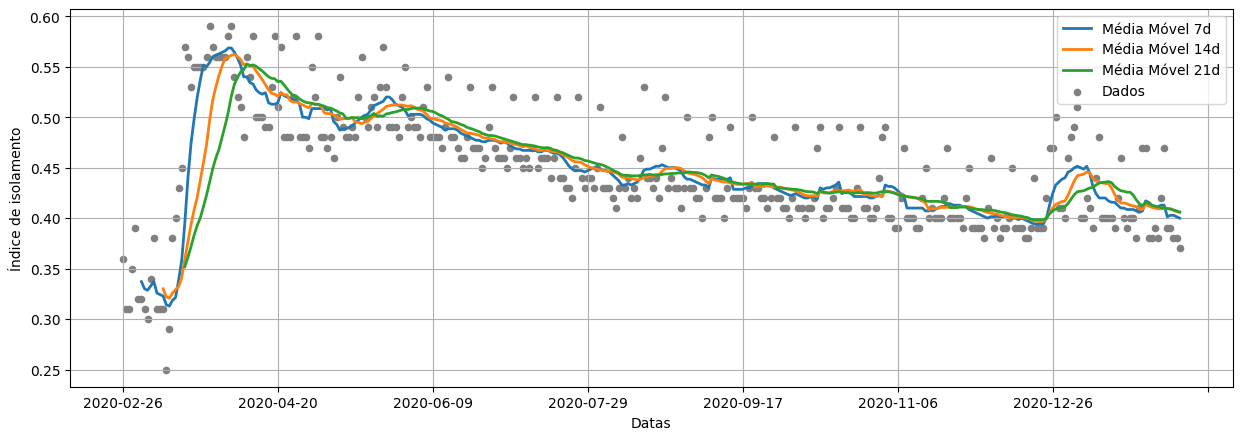

In [3]:
# carregando data do índice de isolamento
saopaulo_isol_data = pd.read_csv("data/SaoPaulo_isolamento.csv")
saopaulo_isol_df = pd.DataFrame(saopaulo_isol_data)
saopaulo_isol_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
saopaulo_isol_df = saopaulo_isol_df.rename(columns={'Isol':'Dados'})
#print(saopaulo_isol_df.head())
saopaulo_isol_df['SMA 7'] = saopaulo_isol_df.iloc[:, 1].rolling(window=7).mean()
saopaulo_isol_df['SMA 14'] = saopaulo_isol_df.iloc[:, 1].rolling(window=14).mean()
saopaulo_isol_df['SMA 21'] = saopaulo_isol_df.iloc[:, 1].rolling(window=21).mean()
#
ax1 = saopaulo_isol_df.plot(x='Data', y='SMA 7', kind='line', linewidth=2)
ax2 = saopaulo_isol_df.plot(x='Data', y='SMA 14', kind='line', linewidth=2, ax=ax1)
ax3 = saopaulo_isol_df.plot(x='Data', y='SMA 21', kind='line', linewidth=2, ax=ax2)
saopaulo_isol_df.plot(x='Data', y='Dados', kind='scatter', color='gray', ax=ax3)
plt.legend(['Média Móvel 7d', 'Média Móvel 14d', 'Média Móvel 21d', 'Dados'])
plt.xlabel('Datas')
plt.ylabel('Índice de isolamento')
plt.grid()
plt.show()

Ajustamos os dados reais com polinômios de 5, 6 e 7 ordem. 

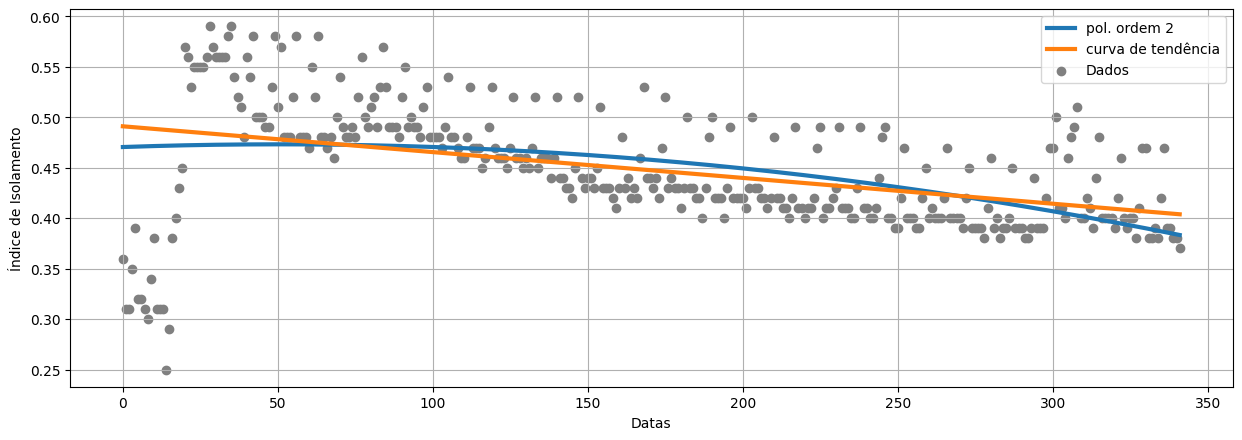

In [4]:
# Ajustando os polinômios com dados crus 
X = np.arange(0,saopaulo_isol_df['Dados'].size, 1)
#
coefs9, stats9 = poly.polyfit(X, saopaulo_isol_df['Dados'].to_numpy(), 9, full=True)
ffit9 = np.polynomial.Polynomial(coefs9)
#
coefs7, stats7 = poly.polyfit(X, saopaulo_isol_df['Dados'].to_numpy(), 7, full=True)
ffit7 = np.polynomial.Polynomial(coefs7)
#
coefs5, stats5 = poly.polyfit(X, saopaulo_isol_df['Dados'].to_numpy(), 5, full=True)
ffit5 = np.polynomial.Polynomial(coefs5)
#
coefs3, stats3 = poly.polyfit(X, saopaulo_isol_df['Dados'].to_numpy(), 3, full=True)
ffit3 = np.polynomial.Polynomial(coefs3)
#
coefs2, stats2 = poly.polyfit(X, saopaulo_isol_df['Dados'].to_numpy(), 2, full=True)
ffit2 = np.polynomial.Polynomial(coefs2)
#
coefs1, stats1 = poly.polyfit(X, saopaulo_isol_df['Dados'].to_numpy(), 1, full=True)
ffit1 = np.polynomial.Polynomial(coefs1)
#
plt.scatter(X,saopaulo_isol_df['Dados'].to_numpy(), color='gray', label='Dados')
#plt.plot(X,ffit9(X), linewidth=3, label='pol. ordem 9')
#plt.plot(X,ffit7(X), linewidth=3, label='pol. ordem 7')
#plt.plot(X,ffit5(X), linewidth=3, label='pol. ordem 5')
#plt.plot(X,ffit3(X), linewidth=3, label='pol. ordem 3')
plt.plot(X,ffit2(X), linewidth=3, label='pol. ordem 2')
plt.plot(X,ffit1(X), linewidth=3, label='curva de tendência')
plt.legend()
plt.grid()
plt.xlabel('Datas')
plt.ylabel('Índice de Isolamento')
plt.show()

A partir de um polinômio de ordem 9, comparamos dos tipos de fontes de dados:
1. utilizando a média móvel de 7 dias como fonte de dados;
2. utilizando os dados reais.

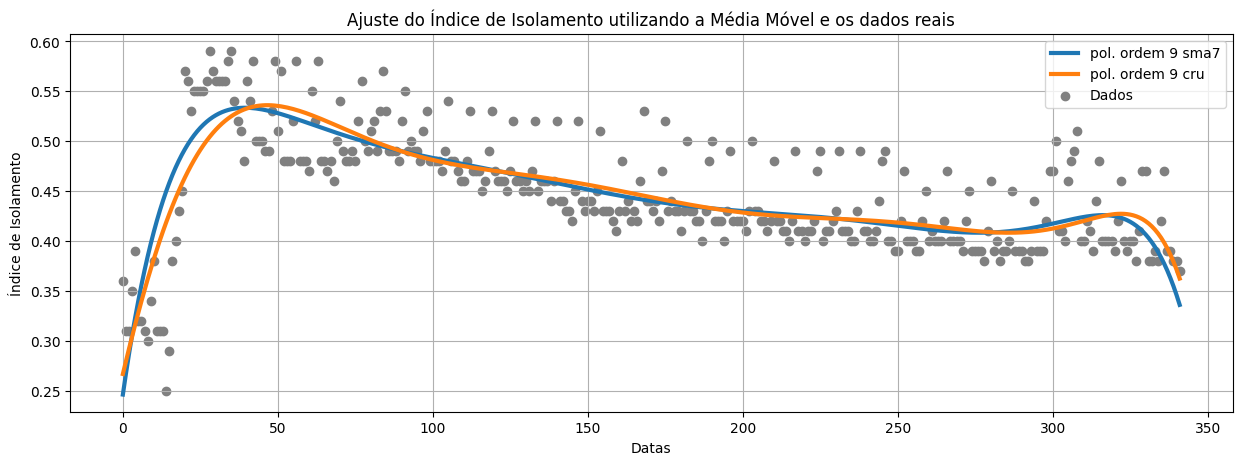

In [5]:
# preparando a data
sma7 = saopaulo_isol_df['SMA 7'].to_numpy()
sma7 = sma7[~np.isnan(sma7)]
X1 = np.arange(0,sma7.size, 1)
coefs9_sma7, stats9_sma7 = poly.polyfit(X1, sma7, 9, full=True)
ffit9_sma7 = np.polynomial.Polynomial(coefs9_sma7)
plt.scatter(X,saopaulo_isol_df['Dados'].to_numpy(), color='gray', label='Dados')
plt.plot(X,ffit9_sma7(X), linewidth=3, label='pol. ordem 9 sma7')
plt.plot(X,ffit9(X), linewidth=3, label='pol. ordem 9 cru')
plt.legend()
plt.grid()
plt.xlabel('Datas')
plt.ylabel('Índice de Isolamento')
plt.title('Ajuste do Índice de Isolamento utilizando a Média Móvel e os dados reais')
plt.show()

# Dados públicos do Covid-19
Obtidos do site: https://www.seade.gov.br/coronavirus/

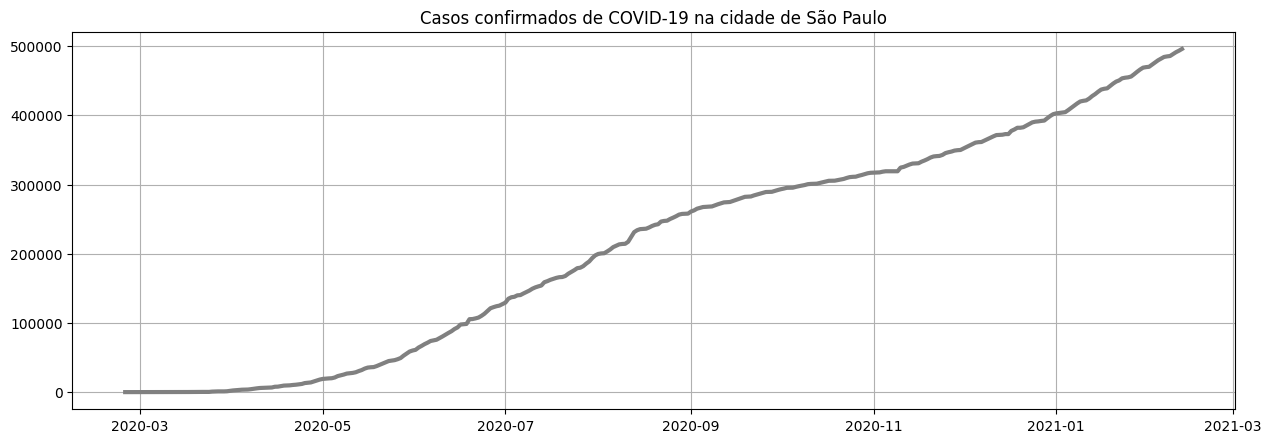

In [6]:
# Carregando os dados para São Paulo
saopaulo_covid_df = pd.read_csv("data/SaoPaulo_dados_covid.csv")
saopaulo_covid_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
saopaulo_covid_df.head()
plt.plot(pd.to_datetime(saopaulo_covid_df['datahora']),saopaulo_covid_df['casos'].to_numpy(), 
         color='gray', linewidth=3)
plt.title('Casos confirmados de COVID-19 na cidade de São Paulo')
plt.grid()
plt.show()
# Convertindo dados para uso futuro na otimização
# convertindo data-frame em array
saopaulo_covid_casos = saopaulo_covid_df['casos'].to_numpy()
# população total de São Paulo
saopaulo_tot_pop = int(saopaulo_covid_df['pop'].mean())
# vetor dos dias registrados 
saopaulo_dias = pd.to_datetime(saopaulo_covid_df['datahora'], yearfirst=True)
# vetor 0, 1, ..., N do tamanho das amostras coletadas
saopaulo_tempo = np.arange(0, saopaulo_covid_casos.size, 1)
# número de amostras
N = saopaulo_tempo.size

Definições gerais utilizadas pelo *fit*

In [7]:
# Taxa diaria de nacimentos e mortes
mu = 2e-5   

# Ajustando o modelo de Covid-19 aos dados públicos
O objetivo é ajustar os parâmetros do modelo:
\begin{align}
\begin{split}
\dfrac{ds}{dt}&=\mu+\gamma -\alpha(1-\theta)si-(\mu+\gamma) s -\gamma i -\gamma s_{ick}\\
%
\dfrac{di}{dt}&=\alpha(1-\theta)si-(\beta_1+\beta_2+\mu)i\\
\dfrac{ds_{ick}}{dt}&=\beta_2i-(\beta_3+\mu)s_{ick}
\end{split}
\label{eq:constant-perc-pop-reduced-model}
\end{align}
com o índice de isolamento $\theta$ assumindo diferentes funções:
1. $\theta_1$ uma constante igual á média aritmética dos dados públicos;
2. $\theta_2(t)=at+b$, uma reta de tendência;
3. $\theta_3(t)=a_9t^9+\cdots+a_1t+a_0$, Um polinômio de ordem 9.

Para modelar a curva de casos confirmados de COVID-19 na cidade de São Paulo.

---

Funções a serem utilizadas

In [8]:
def rhs(t,x,p):
    # O lado direito da função    
    # ds/dt = mu + gamma - alpha(1-theta)*s*i - (mu + gamma)*s - gamma*i - gamma*sick
    # di/dt = alpha*(1-theta)*s*i - (beta1 + beta2 + mu)*i
    # dsick/dt = beta2*i - (beta3 + mu)* sick
    #
    # this is the right-hand side funtion, implemented for numertical integration
    s = x[0]
    i = x[1]
    sick = x[2]
    mu = p[0]
    gamma = p[1]
    alpha = p[2]
    #theta = p[3]
    beta1 = p[3]
    beta2 = p[4]
    beta3 = p[5]
    return np.array([mu+gamma-alpha*(1-theta(t))*s*i-(mu+gamma)*s-gamma*i-gamma*sick,
                     alpha*(1-theta(t))*s*i-(beta1+beta2+mu)*i,
                     beta2*i-(beta3+mu)*sick])      

# A função de chamada do optimizador
def f(x,gamma,alpha,beta1,beta2,beta3,s0):
        # in this version I adjust the initial condition so s0 + i0 + r0 = 1
        i0 = 1-s0
        r0 = 0
        x0 = np.array([s0,i0,r0]) # initial condition
        t0 = 0 # simulação comeza no dia 0
        tf = N-1 # até N-1 dias
        h = 1 # o paso de integração é um dia
        p=np.zeros(7)
        p[0] = mu
        p[1] = gamma
        p[2] = alpha
        #p[3] = theta
        p[3] = beta1
        p[4] = beta2
        p[5] = beta3
        t,sol = rk4(lambda t, x: rhs(t, x, p), x0, t0, tf, h)
        return sol[:, 2]

def otimiza():
    # Parâmetros para optimização
    sigma = None
    absolute_sigma = False
    # checar se ha algum NaN ou InF nos dados
    check_finite = True
    # os valores mínimos que os parâmetros podem tomar
    gamma_min = 0.01
    alpha_min = 0.3
    beta1_min = 1/45
    beta2_min = 1/21
    beta3_min = 1/45
    s0_min = 0
    # organizando os parâmetros
    params_min = [gamma_min, alpha_min, beta1_min, beta2_min, beta3_min, s0_min]
    # os valores máximos que os parâmetros podem tomar
    gamma_max = 1
    alpha_max = 2
    beta1_max = 1/7
    beta2_max = 1/5
    beta3_max = 1/15
    s0_max = 0.9999
    # organizando os parâmetros
    params_max = [gamma_max, alpha_max, beta1_max, beta2_max, beta3_max, s0_max]
    # organizando os vetores dos limites inferirior e superior
    bounds = (params_min, params_max)
    # método de otimização (escoler um deles)
    # ‘dogbox’ : dogleg algorithm with rectangular trust regions,
    # 'trf' : Trust Region Reflective algorithm
    method = 'trf'
    # Jacobiano
    jac = None
    # chute inicial para os parâmetros, para ajustar o resultado da simulação podemos ajustar esses chutes iniciais
    gamma_0 = 0.02
    alpha_0 = 0.6
    beta1_0 = 1/14
    beta2_0 = 1/14
    beta3_0 = 1/25
    s0_0 = 0.99
    # organizando os parâmetros
    p0 = np.array([gamma_0, alpha_0, beta1_0, beta2_0, beta3_0, s0_0])
    # a otimização
    print('\nRunning the optimization ...')
    popt, pvoc = optimization.curve_fit(f, saopaulo_tempo, saopaulo_covid_casos/saopaulo_tot_pop, p0, sigma, absolute_sigma, check_finite, bounds,method, jac)
    return(popt, pvoc)

## Com $\theta$ constante igual à média do ìndice de isolamento da cidade de São Paulo

In [9]:
# Calculando a média do índice de isolamento para a cidade de São Paulo
def theta_1(t):
    return(saopaulo_isol_df['Dados'].mean())
print('theta_1 =',theta_1(0))

theta_1 = 0.4474269005847951


In [10]:
theta = theta_1

Rodando a otimização ...

In [11]:
popt_1, pvoc_1 = otimiza()
print('optimização finalizada.')


Running the optimization ...
optimização finalizada.


Testando a otimização

In [12]:
perr = np.sqrt(np.diag(pvoc_1))
print('Standard deviation errors on the parameters = ', perr)
print('\nParameters:')
print('-----------')
print('mu =', mu)
print('theta =', theta)
print('Fitted parameters:')
gamma_opt = popt_1[0]
print('gamma =', gamma_opt)
alpha_opt = popt_1[1]
print('alpha =', alpha_opt)
beta1_opt = popt_1[2]
print('beta1 =', beta1_opt)
beta2_opt = popt_1[3]
print('beta2 =', beta2_opt)
beta3_opt = popt_1[4]
print('beta3 =', beta3_opt)
s0_opt = popt_1[5]
print('s0 =', s0_opt)
i0_opt = 1-s0_opt
print('i0 =', i0_opt)

Standard deviation errors on the parameters =  [1.75812666e+03 4.91677166e+01 2.57479383e+01 1.42576858e+00
 7.70540488e-02 7.17620207e-02]

Parameters:
-----------
mu = 2e-05
theta = <function theta_1 at 0x0000020DBBEFDAF0>
Fitted parameters:
gamma = 0.99999999294334
alpha = 0.32048414388434504
beta1 = 0.1119412873878107
beta2 = 0.04761904765171843
beta3 = 0.06666666664516112
s0 = 0.9975662145101002
i0 = 0.002433785489899809


Simulação numérica

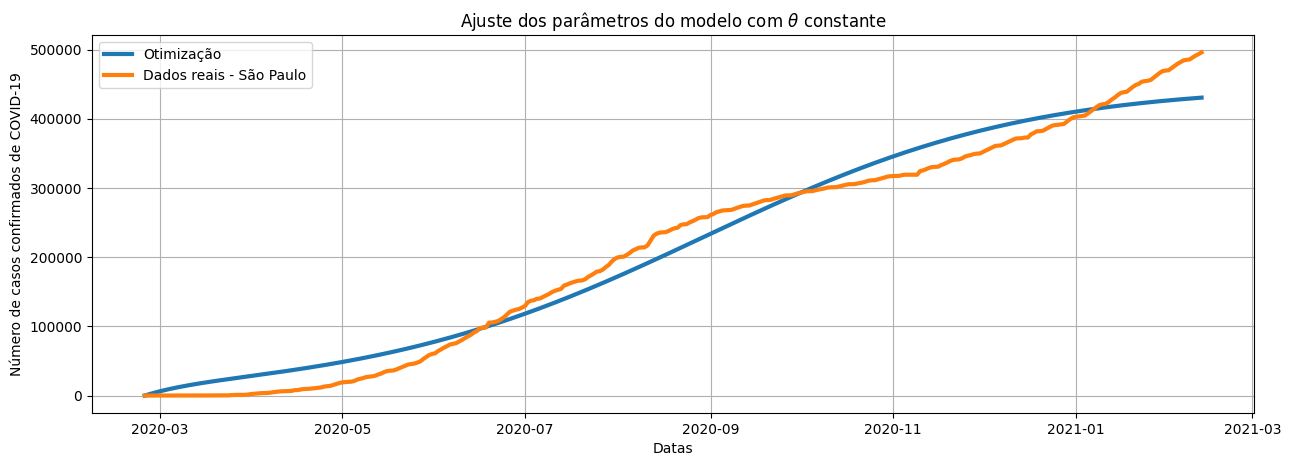

In [13]:
# initial condition
x0 = np.array([s0_opt, i0_opt, 0])
# parameters
t0 = 0
tf = N-1
h = 1
#    
p=np.zeros(7)
p[0] = mu
p[1] = gamma_opt
p[2] = alpha_opt
#p[3] = theta
p[3] = beta1_opt
p[4] = beta2_opt
p[5] = beta3_opt
# rodando Runge-Kutta de 4ta ordem de passo fixo
t, sol =  rk4(lambda t, x: rhs(t, x, p), x0, t0, tf, h)
# o gráfico do ajuste
plt.plot(saopaulo_dias, sol[:,2]*saopaulo_tot_pop, linewidth=3, label='Otimização')
plt.plot(saopaulo_dias, saopaulo_covid_casos, linewidth=3, label='Dados reais - São Paulo')
plt.grid()
plt.legend()
plt.title('Ajuste dos parâmetros do modelo com $\\theta$ constante')
plt.xlabel('Datas')
plt.ylabel('Número de casos confirmados de COVID-19')
plt.show()

## Com $\theta$ constante igual a uma curva de tendência $\theta(t) = at+b$

In [14]:
theta = ffit1

Rodando a otimização ...

In [15]:
popt_1, pvoc_1 = otimiza()
print('optimização finalizada.')


Running the optimization ...
optimização finalizada.


Testando a otimizaçao

In [16]:
perr = np.sqrt(np.diag(pvoc_1))
print('Standard deviation errors on the parameters = ', perr)
print('\nParameters:')
print('-----------')
print('mu =', mu)
print('theta =', theta)
print('Fitted parameters:')
gamma_opt = popt_1[0]
print('gamma =', gamma_opt)
alpha_opt = popt_1[1]
print('alpha =', alpha_opt)
beta1_opt = popt_1[2]
print('beta1 =', beta1_opt)
beta2_opt = popt_1[3]
print('beta2 =', beta2_opt)
beta3_opt = popt_1[4]
print('beta3 =', beta3_opt)
s0_opt = popt_1[5]
print('s0 =', s0_opt)
i0_opt = 1-s0_opt
print('i0 =', i0_opt)

Standard deviation errors on the parameters =  [0.05206508 0.10460217 0.05736013 0.03251976 0.06106435 0.00107367]

Parameters:
-----------
mu = 2e-05
theta = poly([ 4.91004723e-01 -2.55588399e-04])
Fitted parameters:
gamma = 0.08386190840318264
alpha = 0.40310187869982905
beta1 = 0.14285714285035986
beta2 = 0.04761904761904762
beta3 = 0.06666666666666665
s0 = 0.99782324323078
i0 = 0.002176756769220023


Simulação numérica

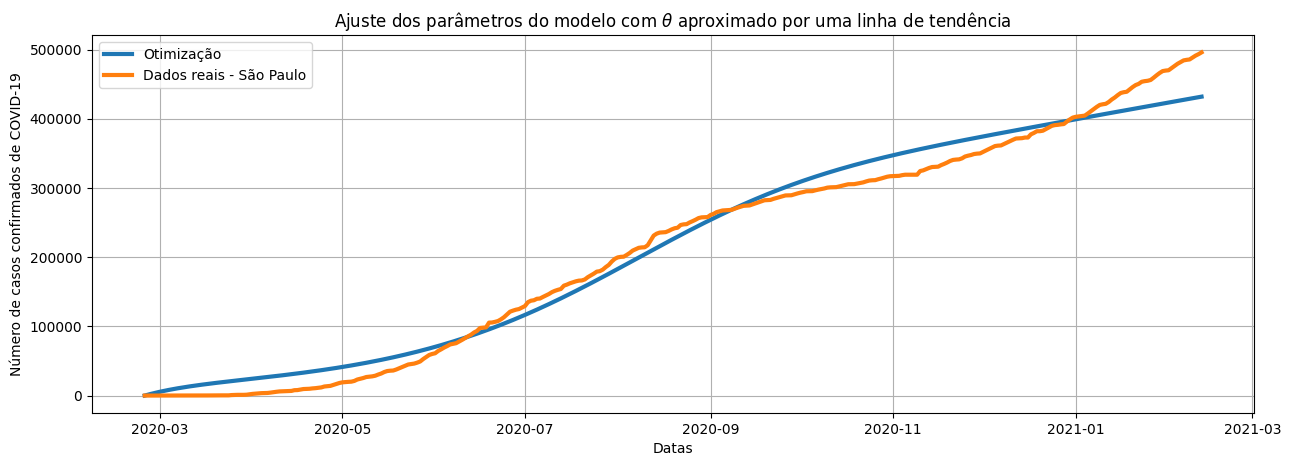

In [17]:
# initial condition
x0 = np.array([s0_opt, i0_opt, 0])
# parameters
t0 = 0
tf = N-1
h = 1
#    
p=np.zeros(7)
p[0] = mu
p[1] = gamma_opt
p[2] = alpha_opt
#p[3] = theta
p[3] = beta1_opt
p[4] = beta2_opt
p[5] = beta3_opt
# rodando Runge-Kutta de 4ta ordem de passo fixo
t, sol =  rk4(lambda t, x: rhs(t, x, p), x0, t0, tf, h)
# o gráfico do ajuste
plt.plot(saopaulo_dias, sol[:,2]*saopaulo_tot_pop, linewidth=3, label='Otimização')
plt.plot(saopaulo_dias, saopaulo_covid_casos, linewidth=3, label='Dados reais - São Paulo')
plt.grid()
plt.legend()
plt.title('Ajuste dos parâmetros do modelo com $\\theta$ aproximado por uma linha de tendência')
plt.xlabel('Datas')
plt.ylabel('Número de casos confirmados de COVID-19')
plt.show()

## Com $\theta$ uma função polinômial de 2da ordem

In [18]:
theta = ffit2

Rodando a otimização ...

In [19]:
popt_1, pvoc_1 = otimiza()
print('optimização finalizada.')


Running the optimization ...
optimização finalizada.


Os parâmetros:

In [20]:
perr = np.sqrt(np.diag(pvoc_1))
print('Standard deviation errors on the parameters = ', perr)
print('\nParameters:')
print('-----------')
print('mu =', mu)
print('theta =', theta)
print('Fitted parameters:')
gamma_opt = popt_1[0]
print('gamma =', gamma_opt)
alpha_opt = popt_1[1]
print('alpha =', alpha_opt)
beta1_opt = popt_1[2]
print('beta1 =', beta1_opt)
beta2_opt = popt_1[3]
print('beta2 =', beta2_opt)
beta3_opt = popt_1[4]
print('beta3 =', beta3_opt)
s0_opt = popt_1[5]
print('s0 =', s0_opt)
i0_opt = 1-s0_opt
print('i0 =', i0_opt)

Standard deviation errors on the parameters =  [8.35538412e-04 1.18479222e-02 5.21618845e-02 4.89752822e-02
 1.94467526e-02 1.07340351e-05]

Parameters:
-----------
mu = 2e-05
theta = poly([ 4.70471757e-01  1.06758060e-04 -1.06259959e-06])
Fitted parameters:
gamma = 0.027691732576644174
alpha = 0.6698685496659278
beta1 = 0.14285714285714196
beta2 = 0.18188395738249627
beta3 = 0.06666666666666665
s0 = 0.9997857652230214
i0 = 0.0002142347769785724


Simulação numerica do ajuste:

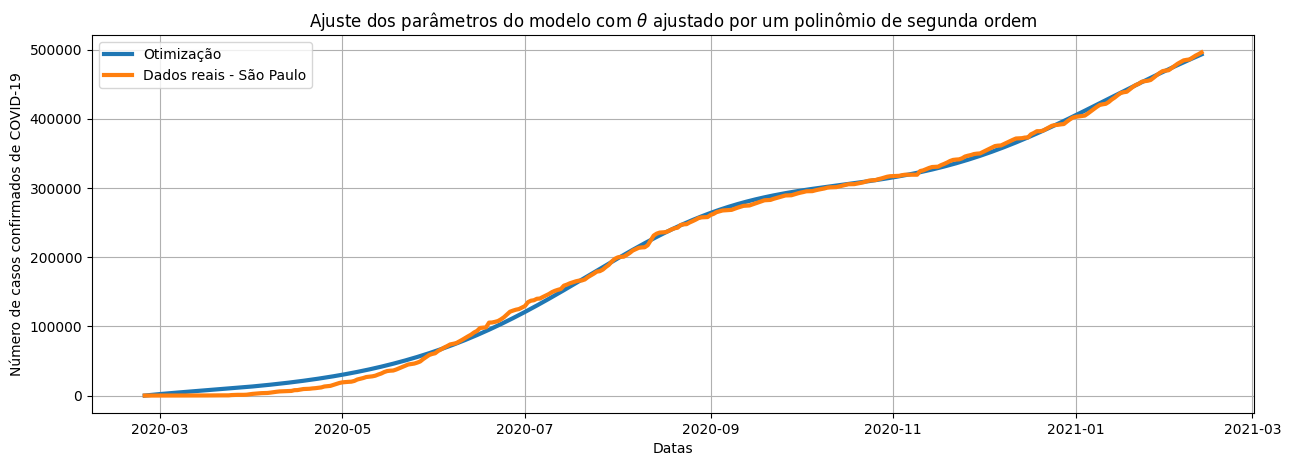

In [21]:
# initial condition
x0 = np.array([s0_opt, i0_opt, 0])
# parameters
t0 = 0
tf = N-1
h = 1
#    
p=np.zeros(7)
p[0] = mu
p[1] = gamma_opt
p[2] = alpha_opt
#p[3] = theta
p[3] = beta1_opt
p[4] = beta2_opt
p[5] = beta3_opt
# rodando Runge-Kutta de 4ta ordem de passo fixo
t, sol =  rk4(lambda t, x: rhs(t, x, p), x0, t0, tf, h)
# o gráfico do ajuste
plt.plot(saopaulo_dias, sol[:,2]*saopaulo_tot_pop, linewidth=3, label='Otimização')
plt.plot(saopaulo_dias, saopaulo_covid_casos, linewidth=3, label='Dados reais - São Paulo')
plt.grid()
plt.legend()
plt.title('Ajuste dos parâmetros do modelo com $\\theta$ ajustado por um polinômio de segunda ordem')
plt.xlabel('Datas')
plt.ylabel('Número de casos confirmados de COVID-19')
plt.show()

# Salvar os parâmetros para uso nas simulações

In [22]:
# salvamos os parâmetros da otimização,
# adicionalmente salvamos a simulação obtida.
parametros_otimos = {
    'Parametros':['mu', 'gamma', 'alpha', 'beta1', 'beta2', 'beta3', 's0', 'i0'],\
    'Valor':[mu, gamma_opt, alpha_opt, beta1_opt, beta2_opt, beta3_opt, s0_opt, i0_opt]}
parametros_df = pd.DataFrame(data=parametros_otimos, columns= ['Parametros', 'Valor'])
parametros_df.to_csv('param_otim.csv', index=False)

In [23]:
simul = np.concatenate((t.reshape(-1,1),sol),axis=1)
simul_df = pd.DataFrame(data=simul, columns=['tempo', 's', 'i', 'sick'])
simul_df.to_csv('simula_otim.csv', index=False)